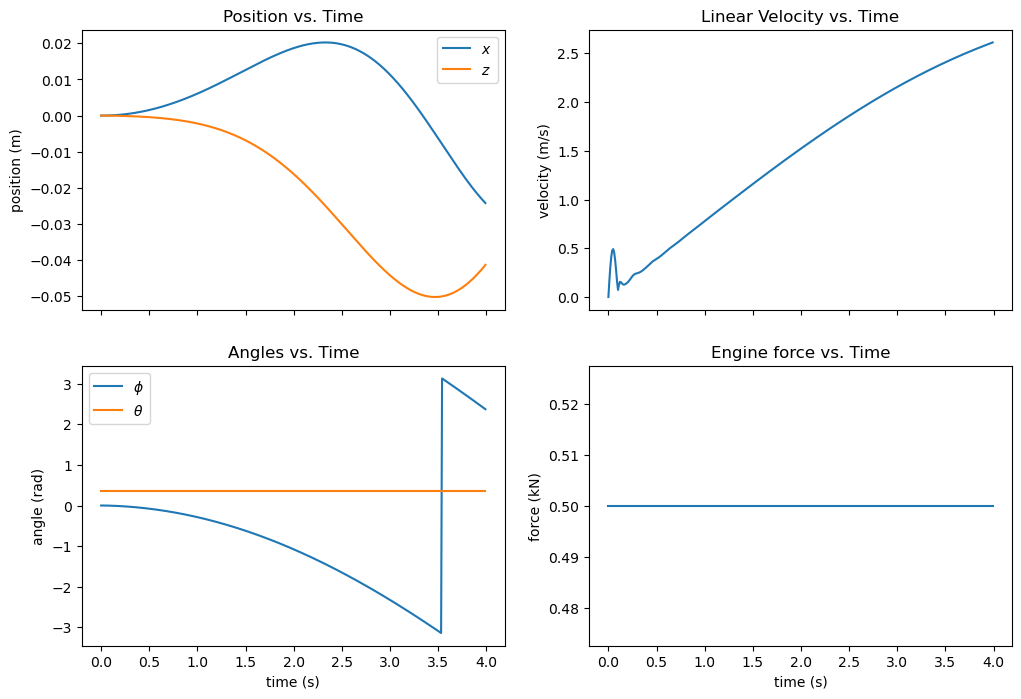

In [5]:
from hybrid_control_car import CarSimulation # The simulation developed for this project
import numpy as np
import scipy as sp
import control as ctrl
import matplotlib.pyplot as plt
import pysindy
import math

nstates = 5 # The number of state variables (x, z, v, n_x, n_z)
ninputs = 2 # The number of inputs (F_e, phi)

def compute_phi(n_x, n_z) -> float:
    phi = 0.0
    
    if n_z == 0:
        if n_x == -1.0: phi = np.pi
    elif n_x == 0.0:
        if n_z == 1.0: phi = np.pi/2.0
        else: phi = 3*np.pi/2.0
    else:
        phi = np.arctan2(n_z, n_x)

    return phi

# Set up the simulation
sim = CarSimulation()
sim.create_floor()

hz = 100 # Timesteps per second
upm = 100 # Units per meter

def simulate(sim: CarSimulation, tstep: int, engine_force: float, steering_angle: float):
    # Convert force to kg*units/timestep^2
    engine_force = engine_force*1000*(hz/upm**2)

    state, colliding, checkpoint, finish = sim.step(tstep, engine_force, steering_angle)
    state = np.array(state)
    # Convert units
    state[0] = state[0]/upm # x
    state[1] = state[1]/upm # z
    state[2] = state[2]*(hz/upm) # v

    return state, colliding, checkpoint, finish

def generate_training_data(sim: CarSimulation, rotation: float, nsamples, nstates, inputs):
    sim.reset_car(rotation)

    data = np.zeros((nsamples, nstates))
    # x, z, v, n_x, n_z
    x0 = np.array([0.0, 0.0, 0.0, np.cos(rotation), np.sin(rotation)])

    for n in range(nsamples):
        engine_force = inputs[n, 0]
        steering_angle = inputs[n, 1]
        state, _, _, _ = simulate(sim, n, engine_force, steering_angle)
        data[n, :] = x0
        x0 = state[:5]

    return data

def plot_data(t, state, input):
    x = state[:, 0]
    z = state[:, 1]
    v = state[:, 2]
    phi = np.arctan2(state[:, 4], state[:, 3])
    Fe = input[:, 0]
    Fe = Fe # Convert to kN
    theta = input[:, 1]

    fig, axs = plt.subplots(2, 2, sharex=True, figsize = (12, 8))
    axs = axs.flatten()

    axs[0].plot(t, x, label='$x$')
    axs[0].plot(t, z, label='$z$')
    axs[0].set_title("Position vs. Time")
    axs[0].set_ylabel("position (m)")
    axs[0].legend()

    axs[1].plot(t, v)
    axs[1].set_title("Linear Velocity vs. Time")
    axs[1].set_ylabel("velocity (m/s)")

    axs[2].plot(t, phi, label=r'$\phi$')
    axs[2].plot(t, theta, label=r"$\theta$")
    axs[2].set_title("Angles vs. Time")
    axs[2].set_xlabel("time (s)")
    axs[2].set_ylabel("angle (rad)")
    axs[2].legend()

    axs[3].plot(t, Fe)
    axs[3].set_title("Engine force vs. Time")
    axs[3].set_xlabel("time (s)")
    axs[3].set_ylabel("force (kN)")

nsteps_test = hz*4
t_test = np.linspace(0, nsteps_test - 1, nsteps_test)
test_inputs = np.array([
    0.5*np.ones(nsteps_test),
    0.35*np.ones(nsteps_test)
]).T
test_states = generate_training_data(sim, 0.0, nsteps_test, nstates, test_inputs)
t_test_seconds = t_test/hz

plot_data(t_test_seconds, test_states, test_inputs)

(5,)
0
0
0
0
0
0
0
0
1
2
5
6
6
6
7
8
11
11
12
12
7
8
10
11
11
11
12
13
15
15
16
16
17
18
21
21
22
22
23
23
26
27
27
27
28
29
32
32
33
33
34
35
38
39
39
39
41
42
45
46
46
46
48
49
53
54
55
55
56
57
62
63
64
64
66
68
73
74
75
75
78
80
87
88
89
89
93
94
103
104
106
106
110
113
123
125
127
127
132
135
148
150
153
153
159
163
179
181
185
185
193
197
217
220
225
225
235
240
264
269
274
274
287
293
324
330
337
337
352
360
399
406
415
415
435
444
494
503
514
514
539
551
614
626
640
640
672
688
769
783
801
801
843
863
968
986
1009
1009
1063
1090
1226
1250
1280
1280
1351
1386
1563
1595
1634
1634
1727
1774
2007
2048
2100
2100
2224
2286
2595
2650
2719
2719
2884
2967
3380
3453
3545
3545
3767
3878
4433
4531
4655
4655
4955
5104
5854
5987
6154
6154
6561
6764
7781
7962
8188
8188
8743
9020
10406
10652
10960
10960
11717
12095
13986
14322
14743
14743
15775
16291
18871
19330
19904
19904
21307
22009
25517
26141
26921
26921
28815
29762
34498
35340
36393
36393
37094
37445
39198
39510
39900
39900


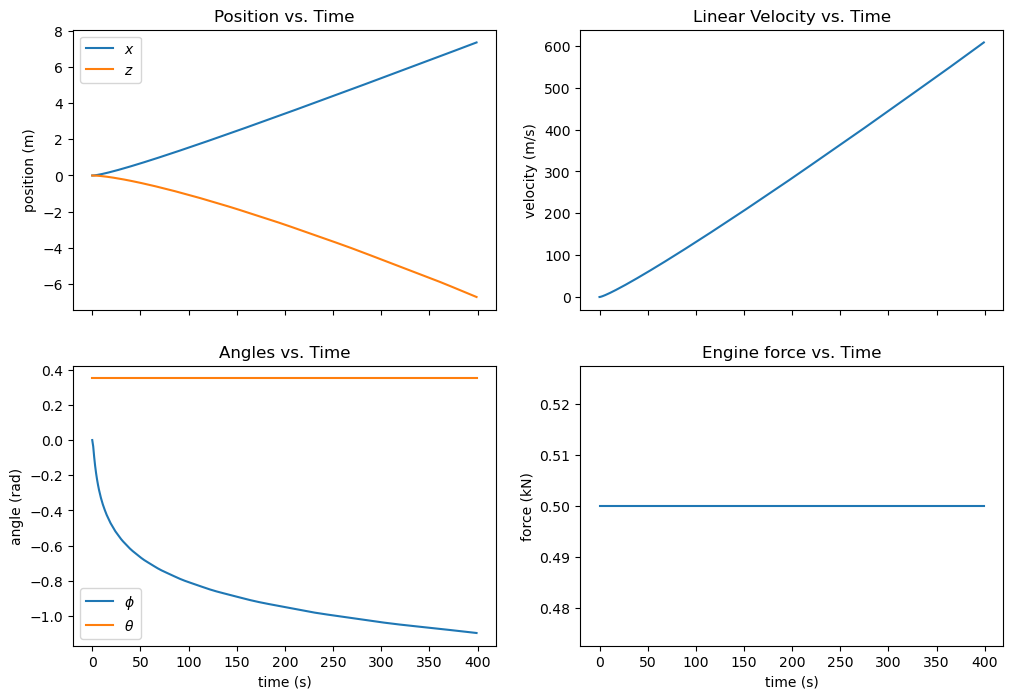

In [8]:
sim.reset_car(0.0)

def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

def _simulation_update(t, x, u, params = {}):
    tstep = math.floor(t*hz)
    print(tstep)

    # Convert force to kg*units/timestep^2
    engine_force = u[0]*1000*(hz/upm**2)
    steering_angle = u[1]

    state, _, _, _ = sim.step(tstep, engine_force, steering_angle)
    state = np.array(state)
    # Convert units
    state[0] = state[0]/upm # x
    state[1] = state[1]/upm # z
    state[2] = state[2]*(hz/upm) # v

    return state[:5]

def _simulation_output(_t, x, _u, params):
    return x

x0 = test_states[0, :]
print(x0.shape)
simulation_sys = ctrl.NonlinearIOSystem(
    _simulation_update, _simulation_output, 
    states = ["x", "z", "v", "n_x", "n_z"],
    inputs = ["Fe", "theta"],
    name = "simulation_sys"
)
response = ctrl.input_output_response(
    simulation_sys, T=t_test, U=test_inputs.T, X0=x0
)
system_states = response.states
system_time = response.time

# print(system_states.T[10, :])
# print(test_states[10, :])
# print(system_time)

plot_data(system_time, system_states.T, test_inputs)